In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open("./names.txt").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(f"{stoi=}")
print(f"{vocab_size=}")

stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
vocab_size=27


In [4]:
import random

random.seed(42)
random.shuffle(words)

In [5]:
block_size = 8

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n8 = int(0.8 * len(words))
n9 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n8])
Xde, Yde = build_dataset(words[n8:n9])
Xte, Yte = build_dataset(words[n9:])

print(Xtr.shape, Ytr.shape)
print(Xde.shape, Yde.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(dim=1)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return x

    def parameters(self):
        return [ p for layer in self.layers for p in layer.parameters() ]

In [8]:
torch.manual_seed(42);

In [17]:
n_embed = 24 # 10
n_hidden = 128 # 68

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.2
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [18]:
# for layer in model.layers:
#     print(layer.__class__.__name__, ":", tuple(layer.out.shape))

In [19]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3100
  10000/ 200000: 2.1456
  20000/ 200000: 2.0849
  30000/ 200000: 2.4555
  40000/ 200000: 2.6188
  50000/ 200000: 2.0150
  60000/ 200000: 1.8543
  70000/ 200000: 1.7702
  80000/ 200000: 1.2896
  90000/ 200000: 2.4410
 100000/ 200000: 2.1648
 110000/ 200000: 2.3849
 120000/ 200000: 1.7986
 130000/ 200000: 1.8528
 140000/ 200000: 1.6792
 150000/ 200000: 1.7034
 160000/ 200000: 1.7060
 170000/ 200000: 1.9147
 180000/ 200000: 1.1174
 190000/ 200000: 2.0199


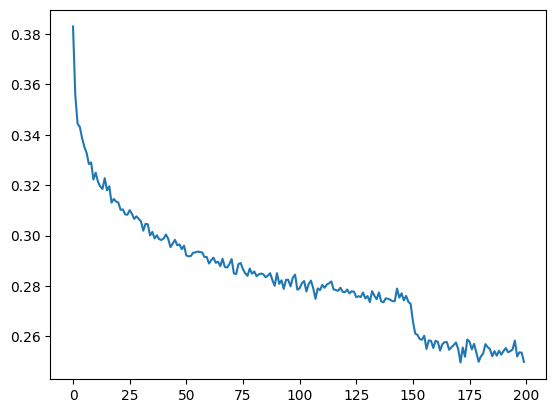

In [20]:
if len(lossi) > 999:
    plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [21]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [22]:
# calc training and dev loss
torch.no_grad() # disables grad tracking
def split_loss(split):
    X, Y = {
        "train": (Xtr, Ytr),
        "dev": (Xde, Yde),
        "test": (Xte, Yte)
    }[split]
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item()) 

split_loss('train')
split_loss('dev')

train 1.7692716121673584
dev 1.9877737760543823


with context 3
```
train 2.0599212646484375
dev 2.1057240962982178
```
with context 8
```
train 1.9170504808425903
dev 2.0332462787628174
```
with hierarchical and flawed BatchNorm1d
```
train 1.938380241394043
dev 2.0253655910491943
```
with hierarchical and proper BatchNorm1d
```
train 1.911864995956421
dev 2.017455577850342
```
with hierarchical and proper BatchNorm1d and params of 76.5k
```
train 1.7692716121673584
dev 1.9877737760543823
```


In [23]:
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

rube.
cauraline.
elyza.
pharanfe.
nasrah.
zephana.
damir.
arsha.
remiel.
sadri.
ronyar.
ahya.
shadie.
tevenleigh.
zaquari.
kinslee.
edyn.
crosmino.
leilan.
syilee.
